In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from fastai.tabular.all import df_shrink
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [2]:
suggested_dtypes = {
'IPV4_SRC_ADDR': 'object',
'L4_SRC_PORT': np.int16,
'IPV4_DST_ADDR': 'object',
'L4_DST_PORT': np.int16,
'PROTOCOL': np.int16,
'L7_PROTO': np.float32,
'IN_BYTES': np.int64,
'IN_PKTS': np.int32,
'OUT_BYTES': np.int64,
'OUT_PKTS': np.int32,
'TCP_FLAGS': np.int16,
'CLIENT_TCP_FLAGS': np.int16,
'SERVER_TCP_FLAGS': np.int16,
'FLOW_DURATION_MILLISECONDS': np.int64,
'DURATION_IN': np.int64,
'DURATION_OUT': np.int64,
'MIN_TTL': np.int16,
'MAX_TTL': np.int16,
'LONGEST_FLOW_PKT': np.int32,
'SHORTEST_FLOW_PKT': np.int32,
'MIN_IP_PKT_LEN': np.int32,
'MAX_IP_PKT_LEN': np.int32,
'SRC_TO_DST_SECOND_BYTES': np.float32,
'DST_TO_SRC_SECOND_BYTES': np.float32,
'RETRANSMITTED_IN_BYTES': np.int32,
'RETRANSMITTED_IN_PKTS': np.int32,
'RETRANSMITTED_OUT_BYTES': np.int32,
'RETRANSMITTED_OUT_PKTS': np.int32,
'SRC_TO_DST_AVG_THROUGHPUT': np.int64,
'DST_TO_SRC_AVG_THROUGHPUT': np.int64,
'NUM_PKTS_UP_TO_128_BYTES': np.int32,
'NUM_PKTS_128_TO_256_BYTES': np.int32,
'NUM_PKTS_256_TO_512_BYTES': np.int32,
'NUM_PKTS_512_TO_1024_BYTES': np.int32,
'NUM_PKTS_1024_TO_1514_BYTES': np.int32,
'TCP_WIN_MAX_IN': np.int32,
'TCP_WIN_MAX_OUT': np.int32,
'ICMP_TYPE': np.int32,
'ICMP_IPV4_TYPE': np.int32,
'DNS_QUERY_ID': np.int32,
'DNS_QUERY_TYPE': np.int32,
'DNS_TTL_ANSWER': np.int32,
'FTP_COMMAND_RET_CODE': np.float32,
'Label': np.int32,
'Attack': 'object'}

In [3]:
path = "/content/drive/MyDrive/NF-BoT-IoT-V2/NF-BoT-IoT-V2.parquet"
df = pq.read_table(path).to_pandas()




In [4]:
df.shape

(30420086, 43)

In [5]:
fraction = 0.05

sampled_df = df.sample(frac=fraction, random_state=42)
sampled_df.to_csv('/content/drive/MyDrive/NF-BoT-IoT-V2/sampled_bot_iot.csv', index=False)

In [ ]:
sampled_df.shape

In [ ]:
sampled_df.head()

In [8]:
list_drop = ['Attack']
# sampled_df = df.copy()
sampled_df.drop(list_drop,axis=1,inplace=True)

In [ ]:
sampled_df.head()

In [10]:
X = sampled_df.iloc[:,:-1]
y = sampled_df.iloc[:,-1]

In [11]:
def select_top_k_pearson(X, y, k=20):
    correlations = []
    for col in X.columns:
        corr, _ = pearsonr(X[col], y)
        correlations.append(abs(corr))

    top_k_indices = np.argsort(correlations)[-k:]
    return X.columns[top_k_indices]

def select_top_k_chi2(X, y, k=20):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    chi2_selector = SelectKBest(chi2, k=k)
    chi2_selector.fit(X_scaled, y)
    return X.columns[chi2_selector.get_support()]

def select_top_k_anova(X, y, k=20):
    anova_selector = SelectKBest(f_classif, k=k)
    anova_selector.fit(X, y)
    return X.columns[anova_selector.get_support()]

def select_top_k_rfe(X, y, k=20):
    model = RandomForestClassifier(random_state=42)
    rfe_selector = RFE(estimator=model, n_features_to_select=k, step=1)
    rfe_selector.fit(X, y)
    return X.columns[rfe_selector.get_support()]

top_20_pearson = select_top_k_pearson(X, y, k=20)
top_20_chi2 = select_top_k_chi2(X, y, k=20)
top_20_anova = select_top_k_anova(X, y, k=20)
top_20_rfe = select_top_k_rfe(X, y, k=20)

# Combine the selected features
# selected_features = set(top_20_pearson).union(set(top_20_chi2)).union(set(top_20_anova))
# Only pearson features
selected_features = set(top_20_rfe)
final_selected_features = list(selected_features)[:20]  # If you want exactly 20 features

# Filter the dataset to keep only the selected features
X_selected = X[final_selected_features]

<ipython-input-11-de6e84870214>:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(X[col], y)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected.values, y.values,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify=y)

In [13]:
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
from sparsemax import Sparsemax
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

# GLU Block
def glu(act, n_units):
    return act[:, :n_units] * torch.sigmoid(act[:, n_units:])

class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank, alpha=1):
        super(LoRALinear, self).__init__()
        self.rank = rank
        self.alpha = alpha

        self.orig_weight = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=False)
        nn.init.kaiming_uniform_(self.orig_weight, a=math.sqrt(5))
        self.U = nn.Parameter(torch.Tensor(out_features, rank))
        self.V = nn.Parameter(torch.Tensor(rank, in_features))
        nn.init.kaiming_normal_(self.U)
        nn.init.kaiming_normal_(self.V)

    def forward(self, x):
        weight = self.orig_weight + self.alpha * self.U @ self.V
        return F.linear(x, weight)

    def extra_repr(self):
        return 'in_features={}, out_features={}, rank={}, alpha={}'.format(
            self.orig_weight.size(1), self.orig_weight.size(0), self.rank, self.alpha
        )

class TabNetModel(nn.Module):
    def __init__(
        self,
        num_features=56,
        feature_dims=56,
        output_dim=56,
        num_decision_steps=6,
        relaxation_factor=0.5,
        batch_momentum=0.001,
        virtual_batch_size=2,
        num_classes=2,
        epsilon=0.00001
    ):
        super().__init__()

        self.num_features = num_features
        self.feature_dims = feature_dims
        self.output_dim = output_dim
        self.num_decision_steps = num_decision_steps
        self.relaxation_factor = relaxation_factor
        self.batch_momentum = batch_momentum
        self.virtual_batch_size = virtual_batch_size
        self.num_classes = num_classes
        self.epsilon = epsilon

        self.feature_transform_linear1 = LoRALinear(num_features, self.feature_dims * 2, rank=16)
        self.BN = torch.nn.BatchNorm1d(num_features, momentum=batch_momentum)
        self.BN1 = torch.nn.BatchNorm1d(self.feature_dims * 2, momentum=batch_momentum)

        self.feature_transform_linear2 = torch.nn.Linear(self.feature_dims * 2, self.feature_dims * 2, bias=False)
        self.feature_transform_linear3 = torch.nn.Linear(self.feature_dims, self.feature_dims * 2, bias=False)
        self.feature_transform_linear4 = torch.nn.Linear(self.feature_dims * 2, self.feature_dims * 2, bias=False)

        self.mask_linear_layer = torch.nn.Linear(self.feature_dims * 2 - output_dim, self.num_features, bias=False)
        self.BN2 = torch.nn.BatchNorm1d(self.num_features, momentum=batch_momentum)

        self.final_classifier_layer = torch.nn.Linear(self.output_dim, self.num_classes, bias=False)
        self.sparsemax = nn.Softmax(dim=1)  # Changed to

    def encoder(self, data):
        batch_size = data.shape[0]
        features = self.BN(data)
        output_aggregated = torch.zeros([batch_size, self.output_dim], dtype=torch.float).to(device)

        masked_features = features
        mask_values = torch.zeros([batch_size, self.num_features]).to(device)

        aggregated_mask_values = torch.zeros([batch_size, self.num_features]).to(device)
        complemantary_aggregated_mask_values = torch.ones([batch_size, self.num_features]).to(device)

        total_entropy = 0

        for ni in range(self.num_decision_steps):
            if ni == 0:
                transform_f1 = self.feature_transform_linear1(masked_features)
                norm_transform_f1 = self.BN1(transform_f1)
                transform_f2 = self.feature_transform_linear2(norm_transform_f1)
                norm_transform_f2 = self.BN1(transform_f2)
            else:
                transform_f1 = self.feature_transform_linear1(masked_features)
                norm_transform_f1 = self.BN1(transform_f1)
                transform_f2 = self.feature_transform_linear2(norm_transform_f1)
                norm_transform_f2 = self.BN1(transform_f2)
                transform_f2 = (glu(norm_transform_f2, self.feature_dims) + transform_f1[:, :self.feature_dims]) * np.sqrt(0.5)
                transform_f3 = self.feature_transform_linear3(transform_f2)
                norm_transform_f3 = self.BN1(transform_f3)
                transform_f4 = self.feature_transform_linear4(norm_transform_f3)
                norm_transform_f4 = self.BN1(transform_f4)
                transform_f4 = (glu(norm_transform_f4, self.feature_dims) + transform_f3[:, :self.feature_dims]) * np.sqrt(0.5)
                decision_out = torch.nn.ReLU(inplace=True)(transform_f4[:, :self.output_dim])
                output_aggregated = torch.add(decision_out, output_aggregated)
                scale_agg = torch.sum(decision_out, axis=1, keepdim=True) / (self.num_decision_steps - 1)
                aggregated_mask_values = torch.add(aggregated_mask_values, mask_values * scale_agg)
                features_for_coef = transform_f4[:, :]
                if ni < (self.num_decision_steps - 1):
                    mask_linear_layer = self.mask_linear_layer(features_for_coef)
                    mask_linear_norm = self.BN2(mask_linear_layer)
                    mask_linear_norm = torch.mul(mask_linear_norm, complemantary_aggregated_mask_values)
                    mask_values = self.sparsemax(mask_linear_norm)
                    complemantary_aggregated_mask_values = torch.mul(complemantary_aggregated_mask_values, self.relaxation_factor - mask_values)
                    total_entropy = torch.add(total_entropy, torch.mean(torch.sum(-mask_values * torch.log(mask_values + self.epsilon), axis=1)) / (self.num_decision_steps - 1))
                    masked_features = torch.mul(mask_values, features)

        return output_aggregated, total_entropy

    def classify(self, output_logits):
        logits = self.final_classifier_layer(output_logits)
        predictions = F.softmax(logits, dim=1)
        return logits, predictions




In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Data Preparation
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_features = X_train_tensor.shape[1]
model = TabNetModel(num_features=num_features, num_classes=2)
#model.load_state_dict(torch.load("/content/drive/MyDrive/NF-BoT-IoT-V2/bot_iot_pretrain.pt"))
model = model.to(device)

for name, param in model.named_parameters():
    if 'U' in name or 'V' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.02)
loss_function = torch.nn.CrossEntropyLoss()

def train_model(model, train_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output, _ = model.encoder(X_batch)
            loss = loss_function(model.classify(output)[0], y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader)

Epoch 1, Loss: 0.08310093955473281
Epoch 2, Loss: 0.01829865805473159
Epoch 3, Loss: 0.012444034882081205
Epoch 4, Loss: 0.00780427937791439
Epoch 5, Loss: 0.010573195577346164
Epoch 6, Loss: 0.008407846624779829
Epoch 7, Loss: 0.006315473280679459
Epoch 8, Loss: 0.0070810679431882175
Epoch 9, Loss: 0.0075481966651507705
Epoch 10, Loss: 0.0066144005232810586


Accuracy: 0.9967126890203813
F1 Score: 0.9983498349834984
Average Precision: 0.997736845944357


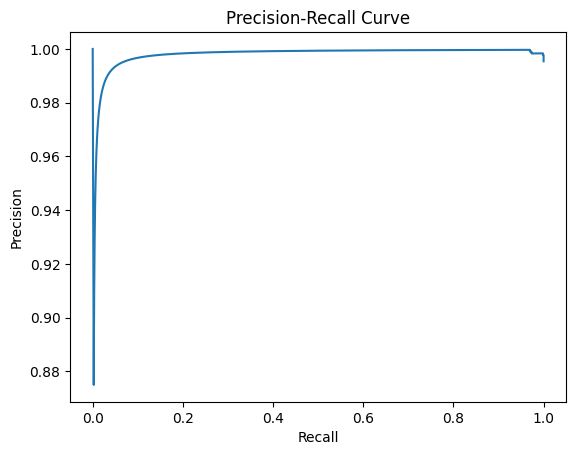

In [19]:

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test_tensor, y_test_tensor):
  model.eval()
  with torch.no_grad():
    X_test_batch = X_test_tensor.to(device)
    y_test_batch = y_test_tensor.to(device)
    output, _ = model.encoder(X_test_batch)
    logits, predictions = model.classify(output)
    accuracy = accuracy_score(y_test_batch.cpu(), predictions.argmax(dim=1).cpu())
    f1 = f1_score(y_test_batch.cpu(), predictions.argmax(dim=1).cpu(), average='binary')
    precision, recall, _ = precision_recall_curve(y_test_batch.cpu(), predictions[:, 1].cpu())
    average_precision = average_precision_score(y_test_batch.cpu(), predictions[:, 1].cpu())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Average Precision:", average_precision)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

  return accuracy, f1, average_precision

# Evaluate the model
accuracy, f1, average_precision = evaluate_model(model, X_test_tensor, y_test_tensor)

In [20]:
torch.save(model.state_dict(), "/content/drive/MyDrive/TabLoRA_pretrained_models/tabnet_bot_iot_v2_rfe.pt")